# SEED IV Dataset Preprocessing

This Notebook can be used in order to preprocess the SEED IV Dataset in the following way: <br/>
1. Collect all the Data form the mat files
2. Remove the baseline from the SEEG Signals
3. Filter the EEG Signals, either with a bandpass filter, a lowpass filter or a highpass filter
4. Downsample the EEG Signals to a certain sampling rate
5. Select only certain EEG Channels and rearange them in a given order
6. Cut the EEG Signals into Windows of given length with given overlap
7. Convert the Labels from Sead/Fear/Neutral/Happy to Negative/Neutral/Positive
8. Safe the generated Dataset
9. Generate some decent plots to compare the old signal with the new signal

## Description, Dataset Access and Citation

<b>For a full description and access to the Dataset please see:</b> <br/>
url: http://bcmi.sjtu.edu.cn/~seed/seed-iv.html <br/>
[1] Zheng, W.; Liu, W.; Lu, Y.; Lu, B.; Cichocki, A.: EmotionMeter: A Multimodal Framework for Recognizing Human Emotions. IEEE Transactions on Cybernetics (2018), p. 1–13. <br/>
<b>If you find this code helpfull please cite:</b><br/>
tbd

## Hyperparameters

In [1]:
data_dir ='../Datasets/raw/SEED_IV/eeg_raw_data'
output_dir = '../Datasets/full_preprocessing/'
baseline_removal_window = 3
cutoff_frequencies = [4,40]
seconds_to_use = 50
downsampling_rate = 128
channels_to_use = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
window_size = 2
window_overlap = 0
convert_labels_to_nnp = True
save_plots_to_file = True

<b>data dir (String)</b>               - the path to the raw SEED Dataset, e.g. "../Datasets/raw/SEED_IV/eeg_raw_data" <br/>
<b>output dir (String)</b>             - the path, where you want to save the preprocessed Dataset, e.g.                                                   "myDatasets/SEED_IV/ <br/>
<b>baseline_removal_window (float)</b> - the timewindow, to calculate a baseline (average) from. This value gets                                             subtracted from the whole timeseries. If you don't want to use baseline_removal,                                   set it to 0 <br/>
<b>cutoff_frequencies (touple)</b>     - the cutoff frequencies for the filter, if the first value ist set to None,                                         allowpass-filtering is used, if the second value is set to None, a highpass filt                                   ist used, if both values are set, a bandpass filter is used <br/>
<b>seconds_to_use (int)</b> - The window in seconds to use from the timeseries, if for example seconds_to_use ist set to 45, only the last 45 seconds will be used. If you want to use the whole timeseries, set it to None <br/>
<b>downsampling_rate (int)</b>         - the frequency, to which the eeg signals should be downsampled. If you don't want to downsample the signal, set it to 0 <br/>
<b>channels_to_use (list)</b> a list of eeg channels you want to use, if you want to use all channels from the dataset, set it to None<br/>
<b>window_size (int)</b>              - the lenght of the timewindow in seconds, the dataset should be cut into <br/>
<b>window_overlap (int)</b>            - overlap of the windows in seconds, if set to 0, the windows don't overlap <br/>
<b>convert_labels_to_nnp (boolean)</b> - wheter or not you want to convert the label classes from sad/fear/neutral/happ to negative/neutral/postive
<b>save_plots_to_file (boolean)</b> - wheter or not you want to save the generated plots, if you choose False, the plots will be only shown in this notebook

## necessary imports

In [2]:
import numpy as np
import scipy.io as sio
from tqdm.notebook import tqdm, trange
import os
import warnings

## Data Collection

In [3]:
sampling_rate = 200
channel_names = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2']

In [4]:
from glob import glob
def get_session_id(subject_id,filename):
    #print(os.path.join(data_dir,subject_id,'_********.mat'))
    files = glob(os.path.join(data_dir,subject_id+'_********.mat'))
    return sorted(files).index(os.path.join(data_dir,filename))

In [5]:
def get_keynames(dict_keys):
    dict_keys = list(dict_keys)
    trial_names = list()
    for trial_name in dict_keys:
        for i in range(1,16):
            if '_eeg'+str(i) in trial_name:
                trial_names.append(trial_name)
    return trial_names

In [6]:
session_label = {}
session_movies = {}
session_label['1'] = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session_label['2'] = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session_label['3'] = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]


session_movies['1'] = ["Black Keys", "The Eye" ,"Rob-B-Hood",
                   "A Bite of China", "The Child's Eye",
                   "A Bite of China", "A Bite of China",
                   "Very Happy", "A Bite of China",
                   "A Wedding Invitation", "Bunshinsaba",
                   "Dearest", "Aftershock" ,"Foster Father",
                   "Bunshinsaba", "Promo for applying the Olympic Winter Games",
                   "Hungry Ghost Ritual", "Hungry Ghost Ritual" ,"Very Happy",
                   "You are my life more complete", "A Bite of China" ,"Hear Me",
                   "A Bite of China" ,"Very Happy"]

session_movies['2'] = ["Annabelle","Secret","Rob-B-Hood","A Bite of China",
                   "A Bite of China","Re-Cycle","A Bite of China","The Child's Eye",
                   "Very Happy","You Are the Apple of My Eye","Bunshinsaba","Hsue-shen Tsien",
                   "1408 phontom horror","A Bite of China","You are my life more complete",
                   "Dearest","Hungry Ghost Ritual","Under the Hawthorn Tree",
                   "A Bite of China","Meet Miss Anxiety","A Bite of China",
                   "Little Daddy","Goodbye Jinhua Station","Foster Father"]

session_movies['3'] = ["Fleet of Time","The House That Never Dies","The Child's Eye",
                   "Dearest","The Stolen Years","Very Happy",
                   "You are my life more complete","Dearest",
                   "Aftershock","The Great Hypnotist","Foster Father",
                   "A Bite of China","Bunshinsaba","Under the Hawthorn Tree",
                   "Very Happy","A Bite of China","Hungry Ghost Ritual","20 Once Again",
                   "A Bite of China","A Bite of China","Hungry Ghost Ritual",
                   "A Bite of China","So Young","A Bite of China"]

In [7]:
X = np.zeros((1080,62,51801))
X_len = np.zeros(1080,dtype=int)
Y = np.zeros((1080,))
session = np.zeros((1080,))
subject = np.zeros((1080,))
trial = np.zeros((1080,))
for session_id in range(1,4):
    for file in tqdm(os.listdir(data_dir+'/'+str(session_id))):
        if file.endswith(".mat"):
            subject_id = file.split('_')[0]
            X_temp = sio.loadmat(os.path.join(data_dir+'/'+str(session_id),file))
            X_temp_keys = get_keynames(X_temp.keys())
            for trial_id in range(1,25):
                experiment_id = (session_id-1)*15*24 + (int(subject_id)-1)*24 + trial_id-1
                subject[experiment_id] = subject_id
                session[experiment_id] = session_id
                trial[experiment_id] = trial_id
                Y[experiment_id] = session_label[str(session_id)][trial_id-1]
                X_temp_exp = X_temp[X_temp_keys[trial_id]]
                X_len[experiment_id] = X_temp_exp.shape[1]
                X[experiment_id,:,:X_temp_exp.shape[1]] = X_temp_exp

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
print("Shape of the Time Series Array X: " + str(X.shape))
print("Unique Label Y Indices: " + str(np.unique(Y)))
print("Unique Session Indices: " + str(np.unique(session)))
print("Unique Subject Indices: " + str(np.unique(subject)))
print("Unique Trial Indices: " + str(np.unique(trial)))
print("Minimum length of Timeseries: " + str(min(X_len)))
print("Maximum length of Timeseries: " + str(max(X_len)))

Shape of the Time Series Array X: (1080, 62, 51801)
Unique Label Y Indices: [0. 1. 2. 3.]
Unique Session Indices: [1. 2. 3.]
Unique Subject Indices: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Unique Trial Indices: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
Minimum length of Timeseries: 10001
Maximum length of Timeseries: 51801


In [9]:
# X_raw is later used for plotting, if you don't want to see the plots, you can uncomment this line
X_raw = X.copy()

## Baseline-Removal

In [10]:
if not(baseline_removal_window==0):
    baseline_datapoints = baseline_removal_window * sampling_rate
    baseline = X[:,:,:baseline_datapoints].sum(2) / baseline_datapoints
    for timestep in trange(X.shape[2]):
        X[:,:,timestep] = X[:,:,timestep] - baseline

  0%|          | 0/51801 [00:00<?, ?it/s]

## Filtering (Bandpass or Highpass or Lowpass)

In [11]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, btype='band', order=5):
        nyq = 0.5 * fs
        if btype == 'bandpass':
            low = lowcut / nyq
            high = highcut / nyq
            sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
        elif btype == 'highpass':
            low = lowcut / nyq
            sos = butter(order, low, analog=False, btype='highpass', output='sos')
        elif btype == 'lowpass':
            high = highcut / nyq
            sos = butter(order, high, analog=False, btype='lowpass', output='sos')
        return sos

def butter_bandpass_filter(X, lowcut, highcut, fs, btype='bandpass', order=5):
        sos = butter_bandpass(lowcut, highcut, fs, btype=btype, order=order)
        X = sosfilt(sos, X)
        return X

In [12]:
if not(cutoff_frequencies[0] == None):
    if not(cutoff_frequencies[1] == None):
        btype='bandpass'
    else:
        btype='highpass'
elif not (cutoff_frequencies[1] == None):
        btype='lowpass'

for experiment_id in trange(X.shape[0]):
    for channel_id in range(X.shape[1]):
        X[experiment_id, channel_id, :] = butter_bandpass_filter(
                                                        X[experiment_id, channel_id, :],
                                                        cutoff_frequencies[0],
                                                        cutoff_frequencies[1],
                                                        sampling_rate,
                                                        btype=btype,
                                                        order=5)

  0%|          | 0/1080 [00:00<?, ?it/s]

## Use only the last n seconds of the timeseries
(As determined with the hyperparameter seconds_to_use)

In [13]:
if not(seconds_to_use == None):
    num_sample_points_to_use = seconds_to_use * sampling_rate
    X_selected = np.zeros((X.shape[0], X.shape[1], num_sample_points_to_use))
    for exp_id in trange(len(X_len)):
        X_selected[exp_id,:,:] = X[exp_id,:,X_len[exp_id]-num_sample_points_to_use:X_len[exp_id]]
    X = X_selected

  0%|          | 0/1080 [00:00<?, ?it/s]

## Downsampling

In [14]:
from scipy.signal import resample

In [15]:
if not(downsampling_rate == 0) and not(downsampling_rate == sampling_rate):
    new_length = int(X.shape[2] / sampling_rate * downsampling_rate)
    X_downsampled = np.zeros((X.shape[0], X.shape[1], new_length))
    for experiment_id in trange(X.shape[0]):
        for channel_id in range(X.shape[1]):
            X_downsampled[experiment_id, channel_id, :] = resample(X[experiment_id, channel_id, :], new_length)
    X = X_downsampled

  0%|          | 0/1080 [00:00<?, ?it/s]

## Select certain channels

In [16]:
if channels_to_use == None:
    channels_to_use = channel_names

In [17]:
channel_index_list = list()
for i in range(len(channels_to_use)):
    if channels_to_use[i] in channel_names:
        channel_index_list.append(channel_names.index(channels_to_use[i]))
    else:
        warnings.warn(' Channel ' + channels_to_use[i] +' could not be found in the list of actual channels')

In [18]:
X_selected_channels = np.zeros((X.shape[0], len(channels_to_use), X.shape[2]))
for channel in trange(len(channel_index_list)):
    X_selected_channels[:,channel,:] = X[:,channel_index_list[channel],:]
X = X_selected_channels

  0%|          | 0/14 [00:00<?, ?it/s]

## Cut into windows

In [19]:
num_points_per_window = window_size * downsampling_rate
num_points_overlap = window_overlap * downsampling_rate
stride = num_points_per_window - num_points_overlap
start_index = [0]
end_index = [num_points_per_window]
num_windows_per_exp = 1
while(end_index[-1]+stride < X.shape[2]):
    num_windows_per_exp = num_windows_per_exp + 1
    start_index.append(start_index[-1] + stride)
    end_index.append(end_index[-1] + stride)
X_cut = np.zeros((num_windows_per_exp*X.shape[0],X.shape[1], num_points_per_window))
Y_cut = np.zeros(num_windows_per_exp*X.shape[0],)
session_cut = np.zeros(num_windows_per_exp*X.shape[0],)
subject_cut = np.zeros(num_windows_per_exp*X.shape[0],)
trial_cut = np.zeros(num_windows_per_exp*X.shape[0],)
for exp_id in trange(X.shape[0]):
    for window_id in range(len(start_index)):
        X_cut[exp_id*num_windows_per_exp+window_id,:,:] = X[exp_id,:,start_index[window_id]:end_index[window_id]]
        Y_cut[exp_id*num_windows_per_exp+window_id] = Y[exp_id]
        session_cut[exp_id*num_windows_per_exp+window_id] = session[exp_id]
        subject_cut[exp_id*num_windows_per_exp+window_id] = subject[exp_id]
        trial_cut[exp_id*num_windows_per_exp+window_id] = trial[exp_id]
X = X_cut
Y = Y_cut
session = session_cut
subject = subject_cut
trial = trial_cut

  0%|          | 0/1080 [00:00<?, ?it/s]

## Label Conversion

In [20]:
if convert_labels_to_nnp:
    Y_nnp = np.copy(Y)
    idx_sad = np.where(Y_nnp==1)
    idx_fear = np.where(Y_nnp==2)
    idx_neutral = np.where(Y_nnp==0)
    idx_happy = np.where(Y_nnp==3)
    print(np.unique(Y_nnp))
    Y_nnp[idx_sad] = -1
    Y_nnp[idx_fear] = -1
    Y_nnp[idx_neutral] = 0
    Y_nnp[idx_happy] = 1
    print(np.unique(Y_nnp))
    Y = Y_nnp

[0. 1. 2. 3.]
[-1.  0.  1.]


## Safe Dataset

Please note: This step can take up to several minutes

In [21]:
np.savez_compressed(
                    output_dir +'/SEED_IV.npz',
                    X=X,
                    Y=Y,
                    session = session,
                    subject = subject,
                    trial = trial,
                    downsampling_rate = downsampling_rate,
                    channel_names = channels_to_use,
                    window_size=window_size,
                    window_overlap = window_overlap,
                    cutoff_frequencies = cutoff_frequencies,
                    baseline_removal_window = baseline_removal_window,
                    seconds_to_use = seconds_to_use
                    )
print('Saved File')

Saved File


## Plots

In [22]:
def perform_FFT(X, sampling_rate):
    n = len(X) # length of the signal
    k = np.arange(n)
    T = n/sampling_rate
    frq = k/T # two sides frequency range
    frq = frq[:len(frq)//2] # one side frequency range

    X_FT = np.fft.fft(X)/n # dft and normalization
    X_FT = X_FT[:n//2]
    return X_FT, frq

In [23]:
channel_id_to_plot = 1

In [24]:
raw_ts = X_raw[0,channel_names.index(channels_to_use[channel_id_to_plot]),0:sampling_rate*window_size]
preprocessed_ts = X[0,channel_id_to_plot,:]

In [25]:
import matplotlib.pyplot as plt

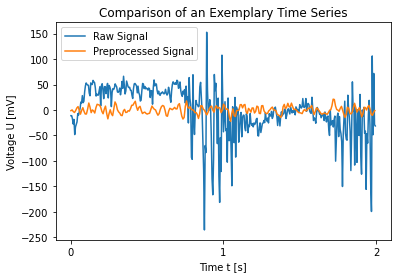

In [26]:
plt.plot(np.arange(0,sampling_rate*window_size),raw_ts, label="Raw Signal")
plt.plot(np.arange(0,downsampling_rate*window_size)/downsampling_rate*sampling_rate,preprocessed_ts, label="Preprocessed Signal")
plt.title("Comparison of an Exemplary Time Series")
plt.xticks([0,sampling_rate,2*sampling_rate],[0,1,2])
plt.xlabel("Time t [s]")
plt.ylabel("Voltage U [mV]")
plt.legend()
if save_plots_to_file:
    plt.savefig(output_dir+'figures/SEED_IV_Timespace.png', facecolor="white")
else:
    plt.show()

In [27]:
raw_fs, raw_frq = perform_FFT(raw_ts, sampling_rate)
preprocessed_fs, preprocessed_frq = perform_FFT(preprocessed_ts, downsampling_rate)

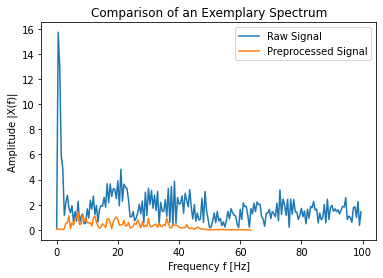

In [28]:
plt.plot(raw_frq, abs(raw_fs), label="Raw Signal")
plt.plot(preprocessed_frq, abs(preprocessed_fs), label="Preprocessed Signal")
plt.title("Comparison of an Exemplary Spectrum")
plt.xlabel("Frequency f [Hz]")
plt.ylabel("Amplitude |X(f)|")
plt.legend()
if save_plots_to_file:
    plt.savefig(output_dir+'figures/SEED_IV_Frequencyspace.png', facecolor="white")
else:
    plt.show()